In [60]:
import pandas as pd
import datetime as dt
import praw
from collections import Counter

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


For the below, follow the directions here https://www.storybench.org/how-to-scrape-reddit-with-python/

In [66]:
PERSONAL_USE_SCRIPT_14_CHARS = 'your personal use'
SECRET_KEY_27_CHARS = 'your secret key'
YOUR_APP_NAME = 'your app name'
YOUR_REDDIT_USER_NAME = 'jbdevtestaccount'
YOUR_REDDIT_LOGIN_PASSWORD = 'your reddit password'

In [67]:
reddit = praw.Reddit(client_id=PERSONAL_USE_SCRIPT_14_CHARS,
                     client_secret=SECRET_KEY_27_CHARS,
                     password=YOUR_REDDIT_LOGIN_PASSWORD,
                     user_agent=YOUR_APP_NAME,
                     username=YOUR_REDDIT_USER_NAME)

In [68]:
print(reddit.user.me())

jbdevtestaccount


In [69]:
subreddit = reddit.subreddit('nosleep')

# Gettting Stories and Comments

In [70]:
stories_dict = {"story_id": [],
                "title": [],
               "author": [],
               "body": []}

In [71]:
comments_dict = {"story_id":[],
                "comment_author": [],
                "comment_body": []}

In [72]:
my_subreddit = subreddit.hot(limit=100)
for submission in my_subreddit:
    stories_dict["title"].append(submission.title)
    stories_dict["body"].append(submission.selftext)
    stories_dict["author"].append(submission.author)
    stories_dict["story_id"].append(submission.id)
    all_comments = submission.comments.list()
    for comment in all_comments:
        comments_dict["story_id"].append(submission.id)
        comments_dict["comment_body"].append(comment.body)
        comments_dict["comment_author"].append(comment.author)

In [73]:
story_df = pd.DataFrame(stories_dict)
story_df.head()

,story_id,title,author,body
0,fdub8s,February 2020 contest nominations,TheCusterWolf,
1,fecu80,January 2020 Winners!,poppy_moonray,
2,flz2nh,How to survive the apocalypse,rikndikndakn123,"With virus outbreaks, global warming, nuclear ..."
3,flozq1,"Whatever you do, don't ever look at the gap be...",not_neccesarily,I was taking the train back home when I first ...
4,flvy6s,I’ve been trapped inside an Empty Prison for t...,Colourblindness,[Part 1](https://www.reddit.com/r/nosleep/comm...


In [74]:
story_df = story_df.drop([0, 1], )
story_df.head()

,story_id,title,author,body
2,flz2nh,How to survive the apocalypse,rikndikndakn123,"With virus outbreaks, global warming, nuclear ..."
3,flozq1,"Whatever you do, don't ever look at the gap be...",not_neccesarily,I was taking the train back home when I first ...
4,flvy6s,I’ve been trapped inside an Empty Prison for t...,Colourblindness,[Part 1](https://www.reddit.com/r/nosleep/comm...
5,fly9ld,The Wolf at the Door,Verastahl,"\n\nThe door opened to a smiling, middle-aged ..."
6,fm014m,"I work for Styx Taxis, I drive souls to the af...",midniteauth0r,"Do something for me, will ya? I want you to t..."


# Testing LDA

In [75]:
# clean text

# remove punctuation
story_df['processed'] = story_df['body'].map(lambda x: re.sub('[,\.!?]', '', x))
story_df.head()

,story_id,title,author,body,processed
2,flz2nh,How to survive the apocalypse,rikndikndakn123,"With virus outbreaks, global warming, nuclear ...",With virus outbreaks global warming nuclear we...
3,flozq1,"Whatever you do, don't ever look at the gap be...",not_neccesarily,I was taking the train back home when I first ...,I was taking the train back home when I first ...
4,flvy6s,I’ve been trapped inside an Empty Prison for t...,Colourblindness,[Part 1](https://www.reddit.com/r/nosleep/comm...,[Part 1](https://wwwredditcom/r/nosleep/commen...
5,fly9ld,The Wolf at the Door,Verastahl,"\n\nThe door opened to a smiling, middle-aged ...",\n\nThe door opened to a smiling middle-aged w...
6,fm014m,"I work for Styx Taxis, I drive souls to the af...",midniteauth0r,"Do something for me, will ya? I want you to t...",Do something for me will ya I want you to thi...


In [76]:
# make it all lower case
story_df['processed'] = story_df['processed'].map(lambda x: x.lower())
story_df.head()

,story_id,title,author,body,processed
2,flz2nh,How to survive the apocalypse,rikndikndakn123,"With virus outbreaks, global warming, nuclear ...",with virus outbreaks global warming nuclear we...
3,flozq1,"Whatever you do, don't ever look at the gap be...",not_neccesarily,I was taking the train back home when I first ...,i was taking the train back home when i first ...
4,flvy6s,I’ve been trapped inside an Empty Prison for t...,Colourblindness,[Part 1](https://www.reddit.com/r/nosleep/comm...,[part 1](https://wwwredditcom/r/nosleep/commen...
5,fly9ld,The Wolf at the Door,Verastahl,"\n\nThe door opened to a smiling, middle-aged ...",\n\nthe door opened to a smiling middle-aged w...
6,fm014m,"I work for Styx Taxis, I drive souls to the af...",midniteauth0r,"Do something for me, will ya? I want you to t...",do something for me will ya i want you to thi...


In [77]:
test = story_df['processed'][2]
test = test.replace('\n',' ')
test = test.replace('*', ' ')
test = test.split()
test = [word for word in test if word not in stopwords.words('english')]
final = ' '.join(test)
final

'virus outbreaks global warming nuclear weapons destructive events matter time world know gone simple rules outlined cdc help stay alive events disasters: &#x200b; 1 trust one chances run humans see wastelands ignore beg help food offer go journey don’t listen follow around get desperate warn dangers close point behind convincing manner don’t acknowledge presence circumstances goes you’re shelter bunker knock door beg let ignore leave may return may hear voices doors loved ones friends ignore can’t harm long ignore eventually sun comes burrow back underground make sure put salt around pile dirt similar pile run wasteland 2 stay inside rain rain acidic burn skin slowly painfully even protective suit find shelter immediately even it’s meager tree come rain long stay cover fine you’re far away shelter try pay attention movement around may see peripheral vision silhouettes moving cover cover always line sight try follow movement let get drop always try attack behind long you’re facing dire

In [78]:
# remove stop words
for index,row in story_df.iterrows():
    story = row['processed']
    story = story.replace('\n',' ')
    story = story.replace('*', ' ')
    story = story.split()
    story = [word for word in story if word not in stopwords.words('english')]
    final = ' '.join(story)
    story_df.at[index,'processed'] = final
    
story_df.head()

,story_id,title,author,body,processed
2,flz2nh,How to survive the apocalypse,rikndikndakn123,"With virus outbreaks, global warming, nuclear ...",virus outbreaks global warming nuclear weapons...
3,flozq1,"Whatever you do, don't ever look at the gap be...",not_neccesarily,I was taking the train back home when I first ...,taking train back home first saw walked train ...
4,flvy6s,I’ve been trapped inside an Empty Prison for t...,Colourblindness,[Part 1](https://www.reddit.com/r/nosleep/comm...,[part 1](https://wwwredditcom/r/nosleep/commen...
5,fly9ld,The Wolf at the Door,Verastahl,"\n\nThe door opened to a smiling, middle-aged ...",door opened smiling middle-aged woman introduc...
6,fm014m,"I work for Styx Taxis, I drive souls to the af...",midniteauth0r,"Do something for me, will ya? I want you to t...",something ya want think back kid think back in...


In [90]:
# Make a TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),max_features=20000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(story_df['processed'])
X.shape

(98, 20000)

In [91]:
terms = vectorizer.get_feature_names()

In [93]:
U, Sigma, VT = randomized_svd(X, n_components=5, n_iter=100,
                              random_state=0)
#printing the concepts
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Concept "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
house
mother
mom
dad
began
family
remember
father
hand
say
 
Concept 1: 
mother
ashlee
dad
mum
sister
remember
father
photo
family
photos
 
Concept 2: 
mother
forest
father
randy
fire
house
woods
cabin
family
remember
 
Concept 3: 
mom
astronaut
sally
louis
closet
doll
cones
school
jagged
suit
 
Concept 4: 
ashlee
mum
photo
photos
sister
forest
water
fire
randy
x200b
 


In [87]:
scores = []
for i in range(2,50):
    km = KMeans(n_clusters=i).fit(X)
    labels = km.labels_
    score = silhouette_score(X, labels, metric='cosine')
    scores.append(score)

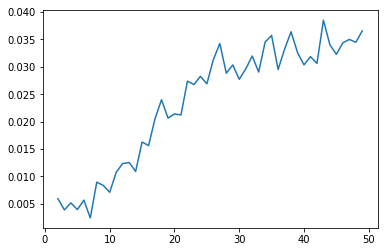

In [88]:
plt.plot(range(2,50),scores)
plt.show()

# Comment Analysis

In [85]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')

My long-distance girlfriend wanted to videocall me, and I think I may have to accept my death
     
It looks like there may be more to this story. Click [here](https://www.reddit.com/message/compose/?to=UpdateMeBot&subject=Subscribe&message=SubscribeMe%21%20%2Fr%2Fnosleep%20%2Fu%2FNaito-desu) to get a reminder to check back later. Got issues? Click [here](https://www.reddit.com/r/nosleep/wiki/nosleepautobot).
NoSleepAutoBot
None
-------
The flower forget-me-not symbolizes true love... maybe it’s a sign that you and ur gf are the real deal
yungmandy
None
-------
Good story
Trimonu
None
-------


# Appendix

In [85]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')

My long-distance girlfriend wanted to videocall me, and I think I may have to accept my death
     
It looks like there may be more to this story. Click [here](https://www.reddit.com/message/compose/?to=UpdateMeBot&subject=Subscribe&message=SubscribeMe%21%20%2Fr%2Fnosleep%20%2Fu%2FNaito-desu) to get a reminder to check back later. Got issues? Click [here](https://www.reddit.com/r/nosleep/wiki/nosleepautobot).
NoSleepAutoBot
None
-------
The flower forget-me-not symbolizes true love... maybe it’s a sign that you and ur gf are the real deal
yungmandy
None
-------
Good story
Trimonu
None
-------
